In [26]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력
W = np.random.rand(7, 3) # 가중치
h = np.matmul(c, W) # 중간 노드
h

array([[0.45355699, 0.36592869, 0.71147923]])

In [27]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [28]:
layer = MatMul(W)
h = layer.forward(c)
h

array([[0.45355699, 0.36592869, 0.71147923]])

In [29]:
# word2vec의 CBOW model 구현

# 샘플 맥락 데이터
c0 = np.array([[1, 0 ,0 ,0 ,0 ,0 ,0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.rand(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
s

array([[-0.11116026,  0.98424813,  2.15748022,  0.03503192, -0.43524595,
         0.14354012,  0.0959269 ]])

In [30]:
# corpus를 단어 ID로 변환해주는 전처리 함수
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [31]:
text = "You say goodbye and I say hello"
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
id_to_word

[0 1 2 3 4 1 5]


{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello'}

In [32]:
# 맥락 및 타깃(유추할 단어) 생성 함수 구현
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target) # 맥락(contexts)과 타겟 반환

In [33]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
target

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]]


array([1, 2, 3, 4, 1])

In [34]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [35]:
# CBOW model 구현
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
# 우선, 마지막에 학습에 사용할 활성화함수 정의, softmax+cross_entropy_error를 합친 SoftmaxWithLoss 함수
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [48]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트화 한다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = (h0+h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None
    
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [49]:
# 최적화 함수
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)


In [54]:
# 학습 함수
def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

import time
import matplotlib.pyplot as plt
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 26 |

| 에폭 497 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 498 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 499 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 500 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 501 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 502 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 503 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 504 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 505 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 506 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 507 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 508 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 509 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 510 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 511 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 512 |  반복 1 / 2 | 시간 0[s] | 손실 0.66
| 에폭 513 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 514 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 515 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 516 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 517 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 518 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 519 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 520 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 521 |  반복 1

/home/dksdudgn00/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dksdudgn00/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dksdudgn00/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dksdudgn00/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


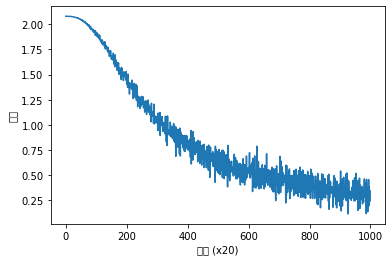

In [55]:
# CBOW 학습시키기
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello. '
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [56]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 0.8545976  -0.7781239  -0.74656653 -1.0234513   1.6780138 ]
say [ 1.2990853   0.14452365  0.65417016  1.3104575  -1.1431248 ]
goodbye [ 0.9234207  -1.0965389  -1.0944246  -1.0504061  -0.23214243]
and [ 0.8903104  -1.5118507   1.582922    1.0955515  -0.88591444]
i [ 1.1907097  -1.2884945  -1.257545   -1.1270308  -0.28103122]
hello [-0.18013678  0.14732763 -0.0120415  -1.3178469   1.7150323 ]
. [ 1.1841048  1.3737202 -1.4731143  1.1115453 -1.0323164]
 [-1.1372851   1.2127652   1.3424643  -1.0838617   0.97369176]
